Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 184MB/s]


Chunk 0 | Epoch 1/15 | Train Loss: 692.9105 | Val Loss: 686.9139
Chunk 0 | Epoch 2/15 | Train Loss: 635.7455 | Val Loss: 585.8204
Chunk 0 | Epoch 3/15 | Train Loss: 609.0770 | Val Loss: 590.2718
Chunk 0 | Epoch 4/15 | Train Loss: 590.7186 | Val Loss: 522.2269
Chunk 0 | Epoch 5/15 | Train Loss: 570.9611 | Val Loss: 548.1936
Chunk 0 | Epoch 6/15 | Train Loss: 554.2330 | Val Loss: 545.9414
Chunk 0 | Epoch 7/15 | Train Loss: 539.6370 | Val Loss: 575.0693
Chunk 0 | Epoch 8/15 | Train Loss: 530.5517 | Val Loss: 424.8782
Chunk 0 | Epoch 9/15 | Train Loss: 520.2812 | Val Loss: 550.1551
Chunk 0 | Epoch 10/15 | Train Loss: 499.5660 | Val Loss: 516.4452
Chunk 0 | Epoch 11/15 | Train Loss: 494.0454 | Val Loss: 521.4804
Chunk 0 | Epoch 12/15 | Train Loss: 478.0925 | Val Loss: 435.3477
Chunk 0 | Epoch 13/15 | Train Loss: 465.1602 | Val Loss: 459.8260
Chunk 0 | Epoch 14/15 | Train Loss: 455.7268 | Val Loss: 468.1839
Chunk 0 | Epoch 15/15 | Train Loss: 445.7679 | Val Loss: 430.0913
Chunk 1 | Epoch 1/1

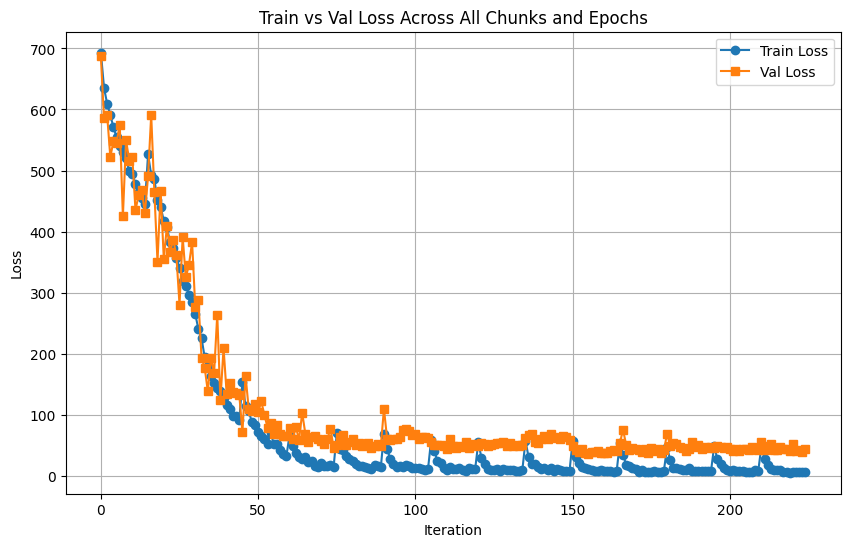

In [2]:

# ============================== 0. Runtime setup ==============================

import tensorflow as tf, numpy as np, pickle, os, random, time, math, json
from pathlib import Path
import matplotlib.pyplot as plt
from google.colab import drive
import torch, numpy as np, tensorflow as tf
import tensorflow as tf, torch, pickle, numpy as np, os, random
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)  # don’t pre-grab all VRAM
tf.keras.mixed_precision.set_global_policy('mixed_float16')  # ½-size tensors
from torch.utils.data import Dataset , DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns
import os
import tensorflow as tf
import pickle
import torch
import torch.nn as nn
import torch.optim as optim


class UTKFaceDataset(Dataset):
    def __init__(self, images, ages, genders, ethnicities):
        self.images = images
        self.ages = ages
        self.genders = genders
        self.ethnicities = ethnicities

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        # Get labels
        age = torch.tensor(self.ages[idx], dtype=torch.float32)
        gender = torch.tensor(self.genders[idx], dtype=torch.float32)
        ethnicity = torch.tensor(self.ethnicities[idx], dtype=torch.long)
        #
        return image, age, gender, ethnicity
# ------------------------------------------------------------------------------
# 1.  Mount Google Drive
# ------------------------------------------------------------------------------
drive.mount('/content/drive')

# ------------------------------------------------------------------------------
# 5.  Model definition (ResNet-152 w/ ReLU age head)
# ------------------------------------------------------------------------------
from tensorflow.keras.layers import (Input, Conv2D, LayerNormalization, ReLU,
                                     Dropout, Add, MaxPooling2D,
                                     GlobalAveragePooling2D, Dense)
from tensorflow.keras.models import Model
import torch, torch.nn as nn
from torchvision.models import resnet34, ResNet34_Weights




class AgeGenderNet(nn.Module):
    def __init__(self, dropout: float = 0.2, unfreeze_layers: list[str] = None):
        super().__init__()
        # Load pretrained ResNet-34 backbone
        self.backbone = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        self.backbone.fc = nn.Identity()  # remove original classification head

        # Determine which backbone layers to unfreeze
        if unfreeze_layers is None:
            unfreeze_layers = ["layer3", "layer4"]

        for name, param in self.backbone.named_parameters():
            param.requires_grad = any(name.startswith(layer) for layer in unfreeze_layers)

        # Shared BatchNorm + Dropout on feature vector
        self.bn_shared = nn.BatchNorm1d(512)
        self.drop_shared = nn.Dropout(dropout)

        # Age regression head
        self.age_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )

        # Gender classification head
        self.gender_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),  # corrected typo: ReLu → ReLU
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        feat = self.backbone(x)        # -> (N, 512) for ResNet-34
        feat = self.bn_shared(feat)
        feat = self.drop_shared(feat)

        age_logits = self.age_head(feat)
        gender_logits = self.gender_head(feat)
        gender_prob = torch.sigmoid(gender_logits)

        return age_logits, gender_prob





device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DROPOUT_RATE=0.2
model = AgeGenderNet(dropout=DROPOUT_RATE).to(device)

import torch.nn as nn
import torch.optim as optim
criterion_age = nn.MSELoss()
criterion_gender = nn.BCELoss()
criterion_ethnicity = nn.CrossEntropyLoss()

# optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1.5e-4,weight_decay=1e-6)




chunk_dir = "/content/drive/MyDrive/pkl_files"
chunk_files = sorted([
    os.path.join(chunk_dir, f) for f in os.listdir(chunk_dir) if f.endswith('.pkl')
])


num_epochs = 15
losses = []
f1_scores = []
# --- 1. Training step ---
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, ages, genders, _ in dataloader:
        if isinstance(images, list):
            images = torch.stack(images)
        images = images.to(device)
        ages   = ages.to(device).unsqueeze(1)
        genders= genders.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        out_age, out_gender = model(images)

        loss_age    = criterion_age(out_age, ages)
        loss_gender = criterion_gender(out_gender, genders)
        loss = 0.5 * loss_age + 1.5 * loss_gender

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(dataloader)

# --- 2. Validation loss only ---
def evaluate_loss(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, ages, genders, _ in dataloader:
            if isinstance(images, list):
                images = torch.stack(images)
            images = images.to(device)
            ages   = ages.to(device).unsqueeze(1)
            genders= genders.to(device).unsqueeze(1).float()

            out_age, out_gender = model(images)
            loss_age    = criterion_age(out_age, ages)
            loss_gender = criterion_gender(out_gender, genders)
            loss = 0.5 * loss_age + 1.5 * loss_gender
            running_loss += loss.item()

    return running_loss / len(dataloader)

# --- 3. Continuous training across chunks ---
train_losses, val_losses = [], []

for i, chunk_path in enumerate(chunk_files[:-9]):
    # Load your chunk as before
    with open(chunk_path, 'rb') as f:
        data = pickle.load(f)
    images = data['images']
    ages   = data['ages']
    genders= data['genders']
    ethnics= data['ethnicities']

    # Build datasets and loaders
    train_df, val_df = train_test_split(list(zip(images, ages, genders, ethnics)),
                                         test_size=0.25, random_state=42)
    train_dataset = UTKFaceDataset(*zip(*train_df))
    val_dataset   = UTKFaceDataset(*zip(*val_df))
    train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader    = torch.utils.data.DataLoader(val_dataset,   batch_size=32, shuffle=False)

    # Epoch loop for this chunk
    for epoch in range(num_epochs):
        tr_loss = train_epoch(model, train_loader, optimizer, device)
        vl_loss = evaluate_loss(model, val_loader, device)

        train_losses.append(tr_loss)
        val_losses.append(vl_loss)

        print(f"Chunk {i} | Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {tr_loss:.4f} | Val Loss: {vl_loss:.4f}")

# --- 4. Plot continuous train vs val loss ---
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses,   label='Val Loss',   marker='s')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Train vs Val Loss Across All Chunks and Epochs')
plt.show()

1002


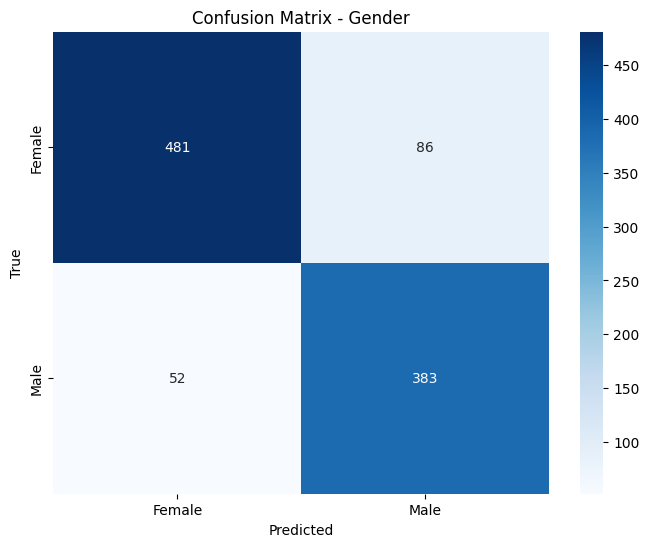

              precision    recall  f1-score   support

         0.0       0.90      0.85      0.87       567
         1.0       0.82      0.88      0.85       435

    accuracy                           0.86      1002
   macro avg       0.86      0.86      0.86      1002
weighted avg       0.87      0.86      0.86      1002



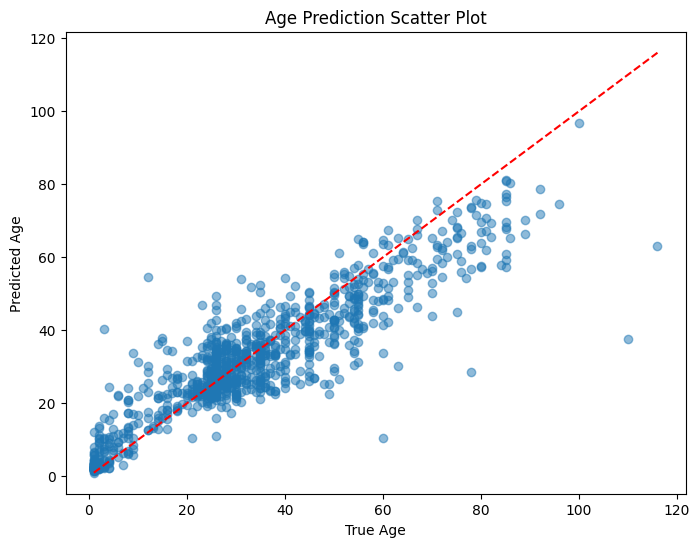

0.7986451829201199
6.371162415383581


In [3]:
#load chunk 17, and run it as a validation
chunk_path = '/content/drive/MyDrive/pkl_files/chunk_17.pkl'
with open(chunk_path, 'rb') as f:
    data_dict = pickle.load(f)

print(len(data_dict['ages']))
df = []
for i in range(len(data_dict['ages'])):
  thing = [data_dict['images'][i], data_dict['ages'][i], data_dict['genders'][i], data_dict['ethnicities'][i]]

  df.append(thing)

val_ages = [row[1] for row in df]
val_genders = [row[2] for row in df]
val_ethnicities = [row[3] for row in df]

val_images = [row[0] for row in df]

val_dataset = UTKFaceDataset(val_images,val_ages,val_genders,val_ethnicities)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


##perform prediction
model.eval().to(device)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)



#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_genders = []
pred_genders = []
true_ethnicities = []
pred_ethnicities = []

with torch.no_grad():
    for images, ages, genders, ethnicities in test_loader:

      images = images.to(device)
      ages = ages.to(device).unsqueeze(1)
      genders = genders.to(device).unsqueeze(1).float()
      out_age, out_gender = model(images)

      true_genders.extend(genders.cpu().numpy())
      pred_genders.extend((out_gender > 0.52).float().cpu().numpy())
      # true_ethnicities.extend(ethnicities.cpu().numpy())
      # pred_ethnicities.extend(out_ethnicity.argmax(dim=1).cpu().numpy())

# Confusion matrix for gender
cm_gender = confusion_matrix(true_genders, pred_genders)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gender, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Gender')
plt.show()

#classfication report
from sklearn.metrics import classification_report
print(classification_report(true_genders, pred_genders))

#confusion matrix for age
true_ages = []
pred_ages = []

with torch.no_grad():
    for images, ages, genders, ethnicities in test_loader:
        images = images.to(device)
        ages = ages.to(device).unsqueeze(1)
        genders = genders.to(device).unsqueeze(1).float()
        out_age, out_gender = model(images)
        true_ages.extend(ages.cpu().numpy())
        pred_ages.extend(out_age.cpu().numpy())

# Scatter plot for age prediction
plt.figure(figsize=(8, 6))
plt.scatter(true_ages, pred_ages, alpha=0.5)
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Age Prediction Scatter Plot')
plt.plot([min(true_ages), max(true_ages)], [min(true_ages), max(true_ages)], 'r--')
plt.show()

#calculate r^2
from sklearn.metrics import r2_score
r2 = r2_score(true_ages, pred_ages)
print(r2)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(true_ages, pred_ages)
print(mae)

In [ ]:
import torch, pathlib
!pip install onnx
import onnx
onnx_path = pathlib.Path("/content/drive/MyDrive/age_gender_34.onnx")

model.eval().cpu()                          # ONNX export needs CPU tensors
dummy = torch.randn(1, 3, 224, 224)         # NCHW, batch-size 1

torch.onnx.export(
    model, dummy, onnx_path,
    input_names  = ["image"],
    output_names = ["age", "gender"],
    dynamic_axes = {"image":  {0: "batch"},
                    "age":    {0: "batch"},
                    "gender": {0: "batch"}},
    opset_version=17,                       # 17 ↔ TF 2.16+
)
print("✅  ONNX written to", onnx_path)